In [111]:
from sklearn.model_selection import cross_val_score, GroupKFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Lasso
import lightgbm as lgb
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
import shap
import pickle
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.colors as mcolors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import gridspec


from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv
from sklearn.preprocessing import StandardScaler

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs



# Settings

In [112]:
data_for = '_ExpMP'

#data_for = '_PredMP'

#data_for = '_NoMP'

In [113]:
model_for = 'LightGBM'

In [114]:
black = '#515265'
red = '#DD706E'
yellow = '#FAAF3A'
blue = '#3A93C2'

In [115]:
file_path = "../Exp_2_Dataset_feature_engineering/Summary_and_dataset/refined_dataset" + data_for + ".csv"

data = pd.read_csv(file_path)
train = data[data['Type'] == 'Train']
test = data[data['Type'] == 'Test']
lab = data[data['Type'] == 'Lab']

In [116]:
overlapping_values = set(train['Drug-solvent system']).intersection(test['Drug-solvent system'])
overlapping_values

set()

In [117]:
def data_processing (dataset):

    X = dataset.drop(['Type', 'Drug', 'Solvent_1', 'Solvent_2', 'Drug-solvent system', 'LogS', 'Class', 'Solubility (g/100g)'], axis = 1)
    Y = dataset['LogS']
    G = dataset['Drug-solvent system']

    return X, Y, G

In [118]:
X_train, Y_train, G_train = data_processing(train)
X_test, Y_test, G_test = data_processing(test)
X_lab, Y_lab, G_lab = data_processing(lab)

# Hyperparameter screening results

In [119]:
pickle_file_path = '../Exp_3_model_training_optimization/Original/Results/BSCV_results' + data_for + '.pkl'

In [120]:
with open(pickle_file_path, 'rb') as handle:
    results = pickle.load(handle)

In [121]:
results

{'DT': {'best_estimator': DecisionTreeRegressor(max_depth=13, max_features='auto', min_samples_leaf=4,
                        min_samples_split=0.01, random_state=0),
  'best_params': OrderedDict([('max_depth', 13),
               ('max_features', 'auto'),
               ('min_samples_leaf', 4),
               ('min_samples_split', 0.01),
               ('splitter', 'best')]),
  'best_score': -0.48703176542106075,
  'optimization_history': {'mean_fit_time': array([0.07498212, 0.05462554, 0.37982523, 0.05096459, 0.31090083,
          0.05377035, 0.05894585, 0.05098057, 0.04774916, 0.04498124,
          0.16159737, 0.17241068, 0.05053773, 0.35096216, 0.37828531,
          0.42069471, 0.41770184, 0.28097439, 0.42552817, 0.42569044,
          0.41929214, 0.41928718, 0.42534022, 0.42163417, 0.42356956,
          0.28075559, 0.05681586, 0.04882989, 0.41857238, 0.25599988,
          0.38840122, 0.42172492, 0.4213613 , 0.41799572, 0.42006328,
          0.25531504, 0.41833825, 0.4188571 , 0.41

# Model evaluation using the literature test set

In [122]:
## Check again
best_model = results[model_for]['best_estimator']

In [123]:
literature_X_scaled = pd.concat([X_train, X_test], ignore_index=True)
literature_Y = pd.concat([Y_train, Y_test], ignore_index=True)

In [124]:
literature_X_scaled

,Solvent_mass_fraction,Temperature (K),Drug_Collected_Melting_temp (K),Drug_Maccs_8,Drug_Maccs_15,Drug_Maccs_17,Drug_Maccs_19,Drug_Maccs_23,Drug_Maccs_24,Drug_Maccs_25,...,Solvent_2_EState_VSA3,Solvent_2_EState_VSA4,Solvent_2_EState_VSA5,Solvent_2_EState_VSA6,Solvent_2_EState_VSA9,Solvent_2_VSA_EState5,Solvent_2_NOCount,Solvent_2_fr_methoxy,Solvent_2_xtb_global_descriptor,Solvent_2_NPR1
0,1.356555,-0.581841,0.839396,-0.103283,-0.095549,-0.070716,-0.231134,-0.202672,2.924313,-0.22516,...,1.860413,1.641052,-0.393643,0.938131,-0.646882,11.589770,0.034258,-0.100769,2.650980,0.431691
1,-1.084714,1.083114,-1.075311,-0.103283,-0.095549,-0.070716,-0.231134,-0.202672,2.924313,-0.22516,...,-0.272608,-0.341898,-0.393643,-0.567846,-0.646882,-0.016175,0.034258,-0.100769,-0.326727,0.136354
2,1.608907,1.083114,-1.075311,-0.103283,-0.095549,-0.070716,-0.231134,-0.202672,2.924313,-0.22516,...,-0.272608,-0.341898,-0.393643,-0.567846,-0.646882,-0.016175,0.034258,-0.100769,-0.326727,0.136354
3,1.272204,1.083114,-1.075311,-0.103283,-0.095549,-0.070716,-0.231134,-0.202672,2.924313,-0.22516,...,-0.272608,-0.341898,-0.393643,-0.567846,-0.646882,-0.016175,0.034258,-0.100769,-0.326727,0.136354
4,0.935502,1.083114,-1.075311,-0.103283,-0.095549,-0.070716,-0.231134,-0.202672,2.924313,-0.22516,...,-0.272608,-0.341898,-0.393643,-0.567846,-0.646882,-0.016175,0.034258,-0.100769,-0.326727,0.136354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26701,0.262097,0.084141,-0.239298,-0.103283,-0.095549,-0.070716,-0.231134,-0.202672,-0.341961,-0.22516,...,2.108745,3.624001,-0.393643,-0.567846,0.882785,-0.016175,0.034258,-0.100769,-0.584021,-1.194810
26702,0.598799,0.084141,-0.239298,-0.103283,-0.095549,-0.070716,-0.231134,-0.202672,-0.341961,-0.22516,...,2.108745,3.624001,-0.393643,-0.567846,0.882785,-0.016175,0.034258,-0.100769,-0.584021,-1.194810
26703,0.935502,0.084141,-0.239298,-0.103283,-0.095549,-0.070716,-0.231134,-0.202672,-0.341961,-0.22516,...,2.108745,3.624001,-0.393643,-0.567846,0.882785,-0.016175,0.034258,-0.100769,-0.584021,-1.194810
26704,-0.411309,0.084141,-0.239298,-0.103283,-0.095549,-0.070716,-0.231134,-0.202672,-0.341961,-0.22516,...,2.108745,3.624001,-0.393643,-0.567846,0.882785,-0.016175,0.034258,-0.100769,-0.584021,-1.194810


In [125]:
best_model.fit(literature_X_scaled, literature_Y)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


LGBMRegressor(bagging_fraction=0.5, feature_fraction=0.5,
              learning_rate=0.08918945401710096, max_depth=20,
              min_child_samples=100, n_estimators=726, n_jobs=6, num_leaves=10,
              random_state=0)

In [126]:
with open(model_for + '.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [127]:
with open(model_for + '.pkl', 'rb') as file:
    best_model = pickle.load(file)


In [128]:
Y_pred = best_model.predict(X_lab)

In [129]:
summary = pd.DataFrame()

summary['Y_pred'] = Y_pred
summary['Y_exp'] = Y_lab.values
summary['Drug'] = lab['Drug'].values
summary['Temperature'] = lab['Temperature (K)'].values
summary['Solvent_mass_fraction'] = lab['Solvent_mass_fraction'].values
summary

,Y_pred,Y_exp,Drug,Temperature,Solvent_mass_fraction
0,0.164500,0.051018,Aspirin,-0.248850,-1.084714
1,0.398993,1.143119,3-Indolepropionic acid,-0.248850,0.935502
2,0.025561,-0.285845,3-Indolepropionic acid,0.750123,-1.084714
3,0.478631,0.946698,3-Indolepropionic acid,0.750123,-0.074606
4,0.673685,1.313949,3-Indolepropionic acid,0.750123,0.935502
5,0.993210,1.297876,Aspirin,-0.248850,0.935502
6,0.731585,1.001880,Aspirin,-0.248850,-0.074606
7,0.389155,0.407800,Aspirin,0.750123,-1.084714
8,0.976559,1.242254,Aspirin,0.750123,-0.074606
9,-0.215637,-0.732561,3-Indolepropionic acid,-0.248850,-1.084714


In [130]:
drug_order = ['Celecoxib', 'Acetaminophen', '3-Indolepropionic acid', 'Aspirin']
summary['Drug'] = pd.Categorical(summary['Drug'], categories=drug_order, ordered=True)

summary_sorted = summary.sort_values(by=['Drug', 'Temperature', 'Solvent_mass_fraction'])

summary_sorted = summary_sorted.reset_index(drop = True)
summary_sorted

,Y_pred,Y_exp,Drug,Temperature,Solvent_mass_fraction
0,-0.185298,-3.061188,Celecoxib,-0.248850,-1.084714
1,0.499529,-0.351141,Celecoxib,-0.248850,-0.074606
2,0.632294,0.685046,Celecoxib,-0.248850,0.935502
3,0.069054,-2.505811,Celecoxib,0.750123,-1.084714
4,0.667447,0.011534,Celecoxib,0.750123,-0.074606
5,0.797169,0.933291,Celecoxib,0.750123,0.935502
6,0.045647,0.568126,Acetaminophen,-0.248850,-1.084714
7,0.778134,1.165377,Acetaminophen,-0.248850,-0.074606
8,1.012040,1.280612,Acetaminophen,-0.248850,0.935502
9,0.315985,0.830016,Acetaminophen,0.750123,-1.084714


In [131]:
file_path = "../Exp_1_Raw_Dataset/Raw_dataset_dataset_20240705.csv"
original_data = pd.read_csv(file_path)

lab_X = original_data[original_data['Type'] == 'Lab']
literature_X = original_data[original_data['Type'] != 'Lab']

In [132]:
literature_X[['Type']].describe()

,Type
count,26706
unique,2
top,Train
freq,19896


In [133]:
cols_of_interest = ['Drug','Drug_ExactMolWt', 'Drug_Melting_temp (K)']

In [134]:
experiment_STD = [0.026547199, 0.007765518, 0.00609362, 0.011489668, 0.009077589, 0.004943748,
                 0.009819746, 0.007260406, 0.020924193, 0.008093572, 0.005818861, 0.009665102,
                0.016553364, 0.008737235, 0.005338153, 0.021981287, 0.023570222, 0.012345814,
                 0.004954186, 0.007637141, 0.003202658, 0.012285287, 0.0108218, 0.005967770]

In [135]:
plot = lab_X[['Drug','Solvent_mass_fraction','Temperature (K)','LogS']]
plot['LogS_SD'] = experiment_STD
plot['Y_pred'] = summary_sorted['Y_pred'].values

plot['AE'] = abs(plot['LogS'] - plot['Y_pred'])
plot


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Drug,Solvent_mass_fraction,Temperature (K),LogS,LogS_SD,Y_pred,AE
26706,Celecoxib,0.2,298.15,-3.061188,0.026547,-0.185298,2.875890
26707,Celecoxib,0.5,298.15,-0.351141,0.007766,0.499529,0.850670
26708,Celecoxib,0.8,298.15,0.685046,0.006094,0.632294,0.052753
26709,Celecoxib,0.2,313.15,-2.505811,0.011490,0.069054,2.574865
26710,Celecoxib,0.5,313.15,0.011534,0.009078,0.667447,0.655913
26711,Celecoxib,0.8,313.15,0.933291,0.004944,0.797169,0.136122
26712,Acetaminophen,0.2,298.15,0.568126,0.009820,0.045647,0.522479
26713,Acetaminophen,0.5,298.15,1.165377,0.007260,0.778134,0.387243
26714,Acetaminophen,0.8,298.15,1.280612,0.020924,1.012040,0.268572
26715,Acetaminophen,0.2,313.15,0.830016,0.008094,0.315985,0.514031


In [136]:
ACM = plot[plot['Drug'] == 'Acetaminophen']

CXB = plot[plot['Drug'] == 'Celecoxib']

IPA = plot[plot['Drug'] == '3-Indolepropionic acid']

ASA = plot[plot['Drug'] == 'Aspirin']

In [137]:
def exp(df, ax, color, drug, ann):

    unique_temperatures = df['Temperature (K)'].unique()
    fontsize = 12

    width = 0.35  
    x = np.arange(len(df['Solvent_mass_fraction'].unique()))
    
    for i, temp in enumerate(unique_temperatures):
        subset = df[df['Temperature (K)'] == temp]
        
        
        bar_color = color
        
        
        ax.bar(x + i * width, subset['LogS'], width=width, label=f'Temperature {temp} K', color=bar_color, edgecolor='black', linewidth=0.5)
        
        
        if temp == 313.15:
            ax.bar(x + i * width, subset['LogS'], width=width, hatch='///', edgecolor='black', fill=False, linewidth=0)

    
    for i, temp in enumerate(unique_temperatures):
        subset = df[df['Temperature (K)'] == temp]
        ax.errorbar(x + i * width, subset['LogS'], yerr=subset['LogS_SD'], fmt='none', color='k', capsize=5)

    ax.set_xlabel('Ethanol Fraction')
    ax.set_ylabel('Experimental LogS')
    ax.set_title(drug)  
    ax.set_xticks(x + width * (len(unique_temperatures) - 1) / 2)
    ax.set_xticklabels(df['Solvent_mass_fraction'].unique())
    
    
    ax.legend().set_visible(False)
    
    
    ax.axhline(y=0, color='black', linewidth=0.5)
    
    ax.annotate(ann, xy=(0, 1.08), xycoords="axes fraction", va="top", ha="left", fontsize=fontsize)



In [138]:
def metrics(df, ax, color, ann):
    
    fontsize = 12
    mae = mean_absolute_error(df['LogS'], df['Y_pred'])
    medae = median_absolute_error(df['LogS'], df['Y_pred'])
    mse = mean_squared_error(df['LogS'], df['Y_pred'])
    rmse = np.sqrt(mse)
    pearson_r = pearsonr(df['LogS'], df['Y_pred'])[0]
    spearman_r = spearmanr(df['LogS'], df['Y_pred'])[0]
    
    metrics = ['MAE', 'MedAE', 'RMSE', 'MSE', 'PCC', 'SCC']
    values = [mae, medae, rmse, mse, pearson_r, spearman_r]

    bars = ax.bar(metrics, values, color=color, edgecolor='black', linewidth=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('Values')
    ax.set_ylim(0, 3.3)
    ax.set_title('')
    
    for bar in bars:
        height = bar.get_height()
        if height >= 0:
            ax.text(bar.get_x() + bar.get_width() / 2, height, 
                    f'{height:.2f}', ha='center', va='bottom')
        else:
            ax.text(bar.get_x() + bar.get_width() / 2, 0, 
                    f'{height:.2f}', ha='center', va='bottom')

    ax.annotate(ann, xy=(0, 1.08), xycoords="axes fraction", va="top", ha="left", fontsize=fontsize)

In [139]:
def scatter(df, ax, color, ann):
    fontsize = 12
    
    
    ax.scatter(df['LogS'], df['Y_pred'], color=color)

    
    max_limit = max(df['LogS'].max(), df['Y_pred'].max())
    min_limit = min(df['LogS'].min(), df['Y_pred'].min())
    ax.set_xlim(min_limit-0.2, max_limit+0.2)
    ax.set_ylim(min_limit-0.2, max_limit+0.2)

    
    ax.set_xlabel('Actual LogS')
    ax.set_ylabel('Predicted LogS')
    ax.set_title(df['Drug'].iloc[0])  

    
    ax.annotate(ann, xy=(0, 1.08), xycoords="axes fraction", va="top", ha="left", fontsize=fontsize)


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


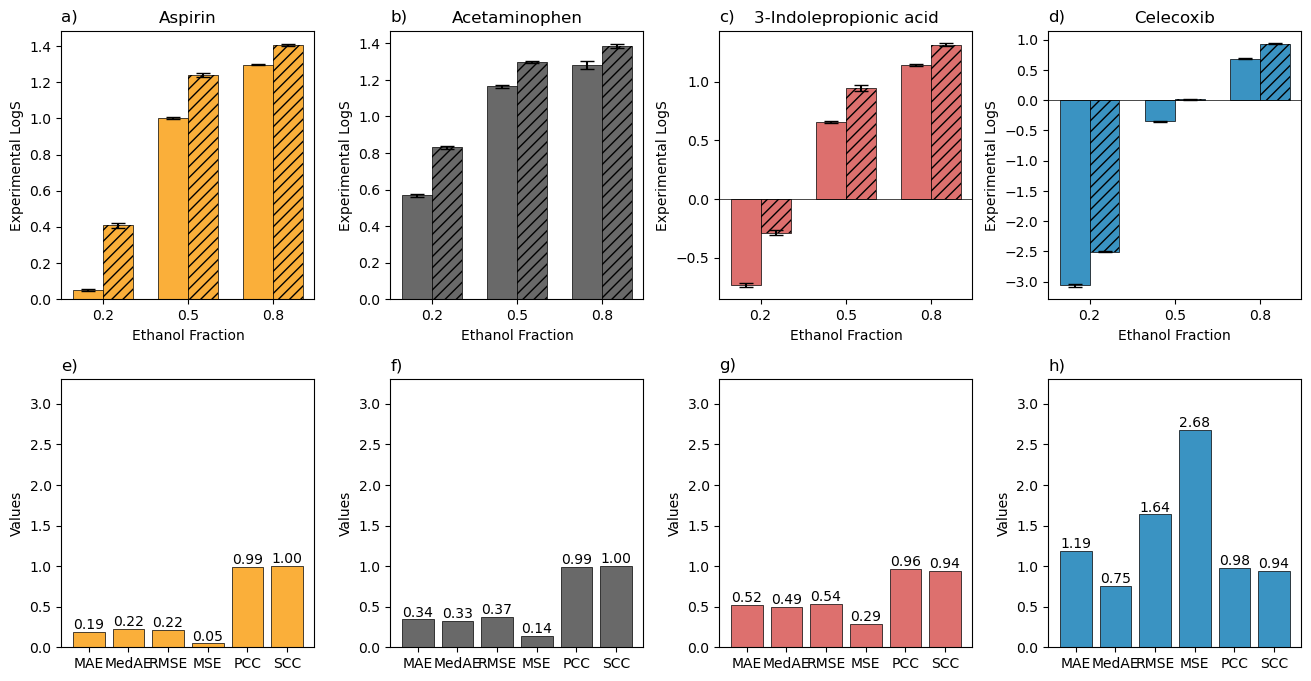

In [140]:
# colors

acm_color = 'dimgray'
ipa_color = red
cxb_color = blue
asa_color = yellow

fig = plt.figure(figsize=(16, 8))
grid = plt.GridSpec(2, 4, wspace=0.3, hspace=0.3)


ax1 = fig.add_subplot(grid[0, 0])
exp(df = ASA, ax = ax1, color = asa_color, ann = 'a)', drug = 'Aspirin')

ax2 = fig.add_subplot(grid[0, 1])
exp(df = ACM, ax = ax2, color = acm_color, ann = 'b)', drug = 'Acetaminophen')


ax3 = fig.add_subplot(grid[0,2])
exp(df = IPA, ax = ax3, color = ipa_color, ann = 'c)', drug = '3-Indolepropionic acid')


ax4 = fig.add_subplot(grid[0, 3])
exp(df = CXB, ax = ax4, color = cxb_color, ann = 'd)', drug = 'Celecoxib')



ax5 = fig.add_subplot(grid[1, 0])
metrics(df = ASA, ax = ax5, color = asa_color, ann = 'e)')

ax6 = fig.add_subplot(grid[1, 1])
metrics(df = ACM, ax = ax6, color = acm_color, ann = 'f)')


ax7 = fig.add_subplot(grid[1,2])
metrics(df = IPA, ax = ax7, color = ipa_color, ann = 'g)')


ax8 = fig.add_subplot(grid[1, 3])
metrics(df = CXB, ax = ax8, color = cxb_color, ann = 'h)')






fig.patch.set(facecolor='none')

plt.tight_layout()

fig.canvas.print_figure('Figure_5_' + model_for + '_Validation' + data_for + '.png', dpi=600)


plt.show()


In [141]:
best_model

LGBMRegressor(bagging_fraction=0.5, feature_fraction=0.5,
              learning_rate=0.08918945401710096, max_depth=20,
              min_child_samples=100, n_estimators=726, n_jobs=6, num_leaves=10,
              random_state=0)

# Model analysis

In [142]:
def plot_feature_importance_lgb(model, ax, selected, ann, importance_type='split', top_n=15, filter_drug_features=True):
    fontsize = 12
    

    if importance_type == 'split':
        importances = model.feature_importances_
    elif importance_type == 'gain':
        importances = model.booster_.feature_importance(importance_type='gain')
    feature_names = model.feature_name_
    

    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    

    if filter_drug_features:
        importance_df = importance_df[importance_df['Feature'].str.startswith('Drug_')]

   
    importance_df_top_n = importance_df.head(top_n)

   
    palette_choice = ['lightcoral' if feature in selected else blue for feature in importance_df_top_n['Feature']]
    bars = sns.barplot(x='Importance', y='Feature', data=importance_df_top_n, ax=ax, palette=palette_choice, edgecolor='black')
    
    
    ax.annotate(ann, xy=(0, 1.025), xycoords="axes fraction", va="top", ha="left", fontsize=fontsize)
    ax.set_title("", fontsize=fontsize)
    
    
    ax.set_xlabel("Feature Importance", fontsize=fontsize)
    ax.set_ylabel("", fontsize=fontsize)

    
    ax.tick_params(axis='x', which='major', labelsize=fontsize)
    ax.tick_params(axis='x', which='minor', labelsize=fontsize)
    ax.tick_params(axis='y', which='major', labelsize=fontsize)
    ax.tick_params(axis='y', which='minor', labelsize=fontsize)
    
    return importance_df_top_n



In [143]:
lab_X['Type'] = lab_X['Drug']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [144]:
def plot_distribution_with_labels_on_trend(ann, prop, ax, show_legend=False, legend_pos = (-0.08, 1.28), ncol = 2):
    fontsize = 12
    
    
    sns.boxplot(y=literature_X[prop], color='lightcoral', fliersize=1, ax=ax)
    
    
    unique_drugs = ['Aspirin','Acetaminophen', '3-Indolepropionic acid', 'Celecoxib']
    colors = [yellow, black, red, blue]
    
    drug_color_map = dict(zip(unique_drugs, colors))
    
    x_positions = np.linspace(-0.0, 0.0, len(unique_drugs))
    
    
    legend_handles = []
    
    
    for idx, drug in enumerate(unique_drugs):
        drug_data = lab_X[lab_X["Drug"] == drug]  
        scatter = ax.scatter([x_positions[idx]] * len(drug_data), drug_data[prop], 
                             color=drug_color_map[drug], label=drug, 
                             alpha=1.0, edgecolor='black', linewidth=0.8, s=180,
                             zorder=10)  
        legend_handles.append(scatter)
    
    ax.set_ylabel('', fontsize=fontsize)
    ax.set_title(prop, fontsize=fontsize)
    
    
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize)
    
    if show_legend:
        ax.legend(handles=legend_handles, title='', loc='upper left', bbox_to_anchor=legend_pos, frameon=False, ncol=ncol, fontsize=fontsize+1)
        
    ax.annotate(ann, xy=(0, 1.05), xycoords="axes fraction", va="top", ha="left", fontsize=fontsize)


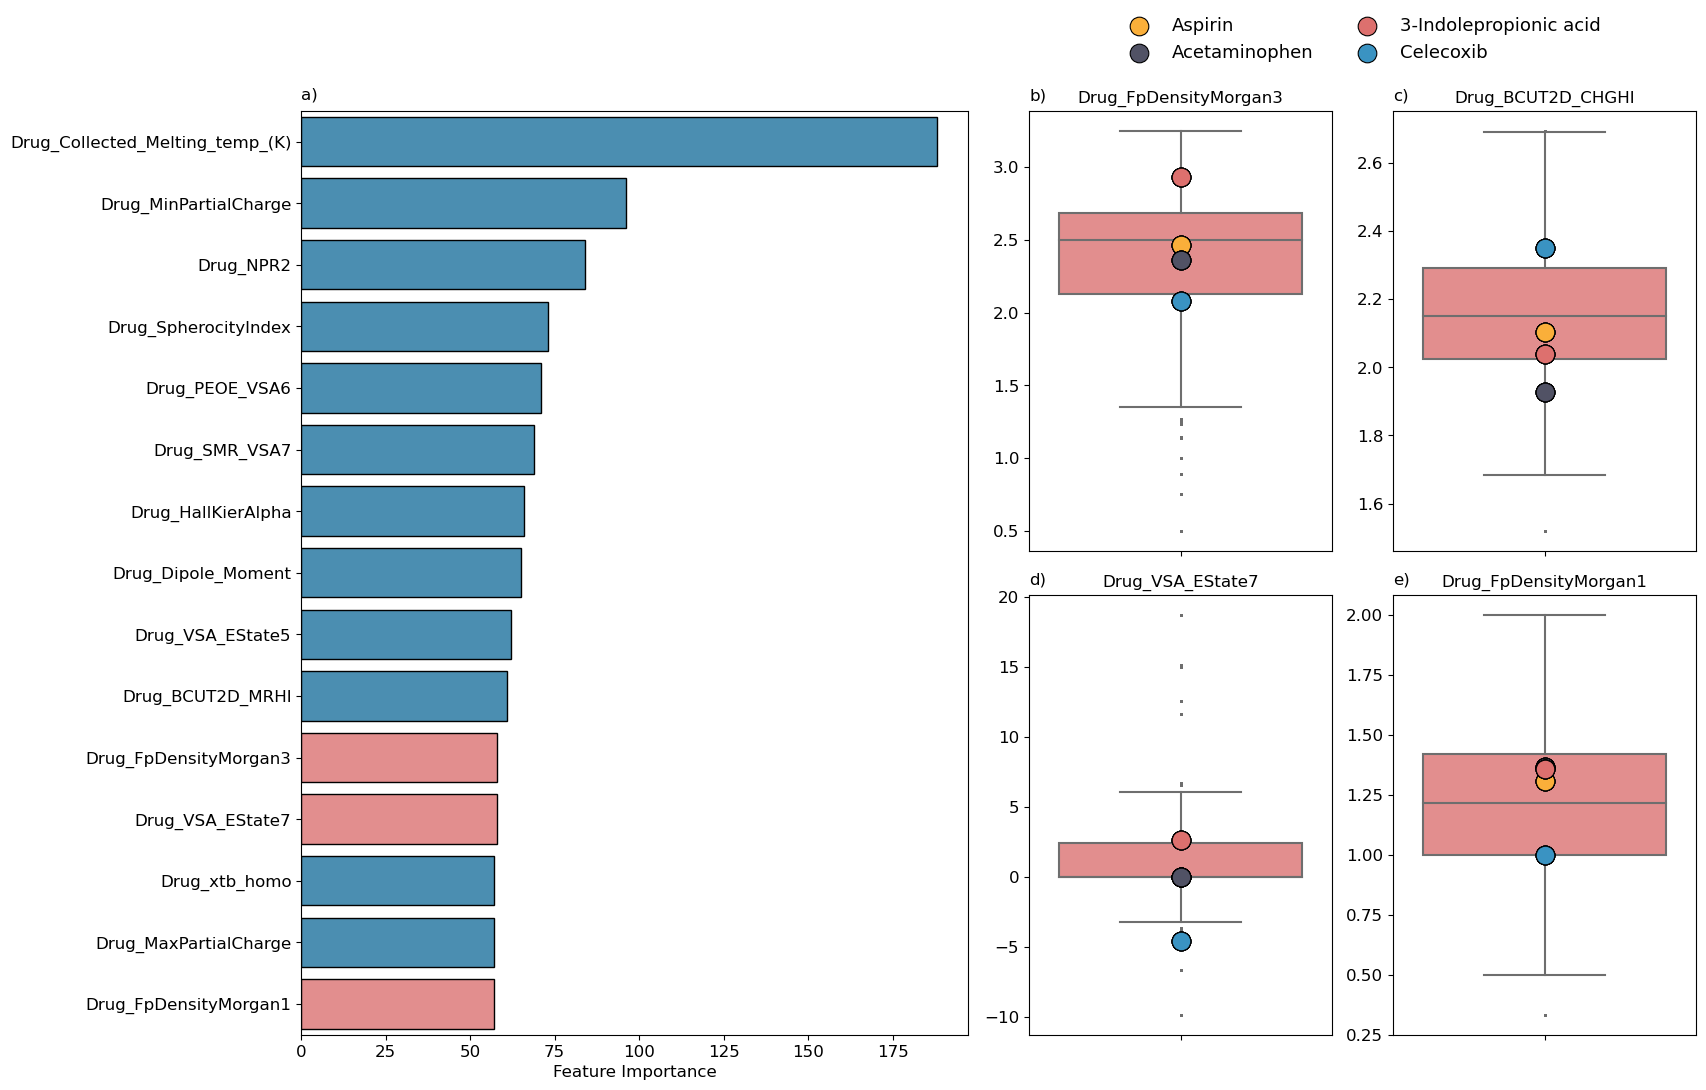

In [145]:
fig = plt.figure(figsize=(18, 12))
grid = gridspec.GridSpec(2, 4, fig, wspace=0.2, hspace=0.1)
selected=['Drug_FpDensityMorgan3','Drug_BCUT2D_CHGHI',  'Drug_VSA_EState7','Drug_FpDensityMorgan1']


ax1 = fig.add_subplot(grid[0:2, 0:2])
important_features = plot_feature_importance_lgb(model=best_model, ax=ax1, selected=selected, ann='a)')


ax2 = fig.add_subplot(grid[0, 2])
plot_distribution_with_labels_on_trend(ann = 'b)',prop='Drug_FpDensityMorgan3', ax=ax2, legend_pos = (0.25, 1.25), ncol = 2, show_legend=True)


ax3 = fig.add_subplot(grid[0, 3])
plot_distribution_with_labels_on_trend(ann = 'c)',prop='Drug_BCUT2D_CHGHI', ax=ax3, show_legend=False)



ax4 = fig.add_subplot(grid[1, 2])
plot_distribution_with_labels_on_trend(ann = 'd)',prop='Drug_VSA_EState7', ax=ax4, show_legend=False)



ax5 = fig.add_subplot(grid[1, 3])
plot_distribution_with_labels_on_trend(ann = 'e)',prop='Drug_FpDensityMorgan1', ax=ax5, show_legend=False)


fig.patch.set(facecolor='none')


fig.canvas.print_figure('Figure_6_' + model_for + data_for + '_Interpretation.png', dpi=600)


plt.show()


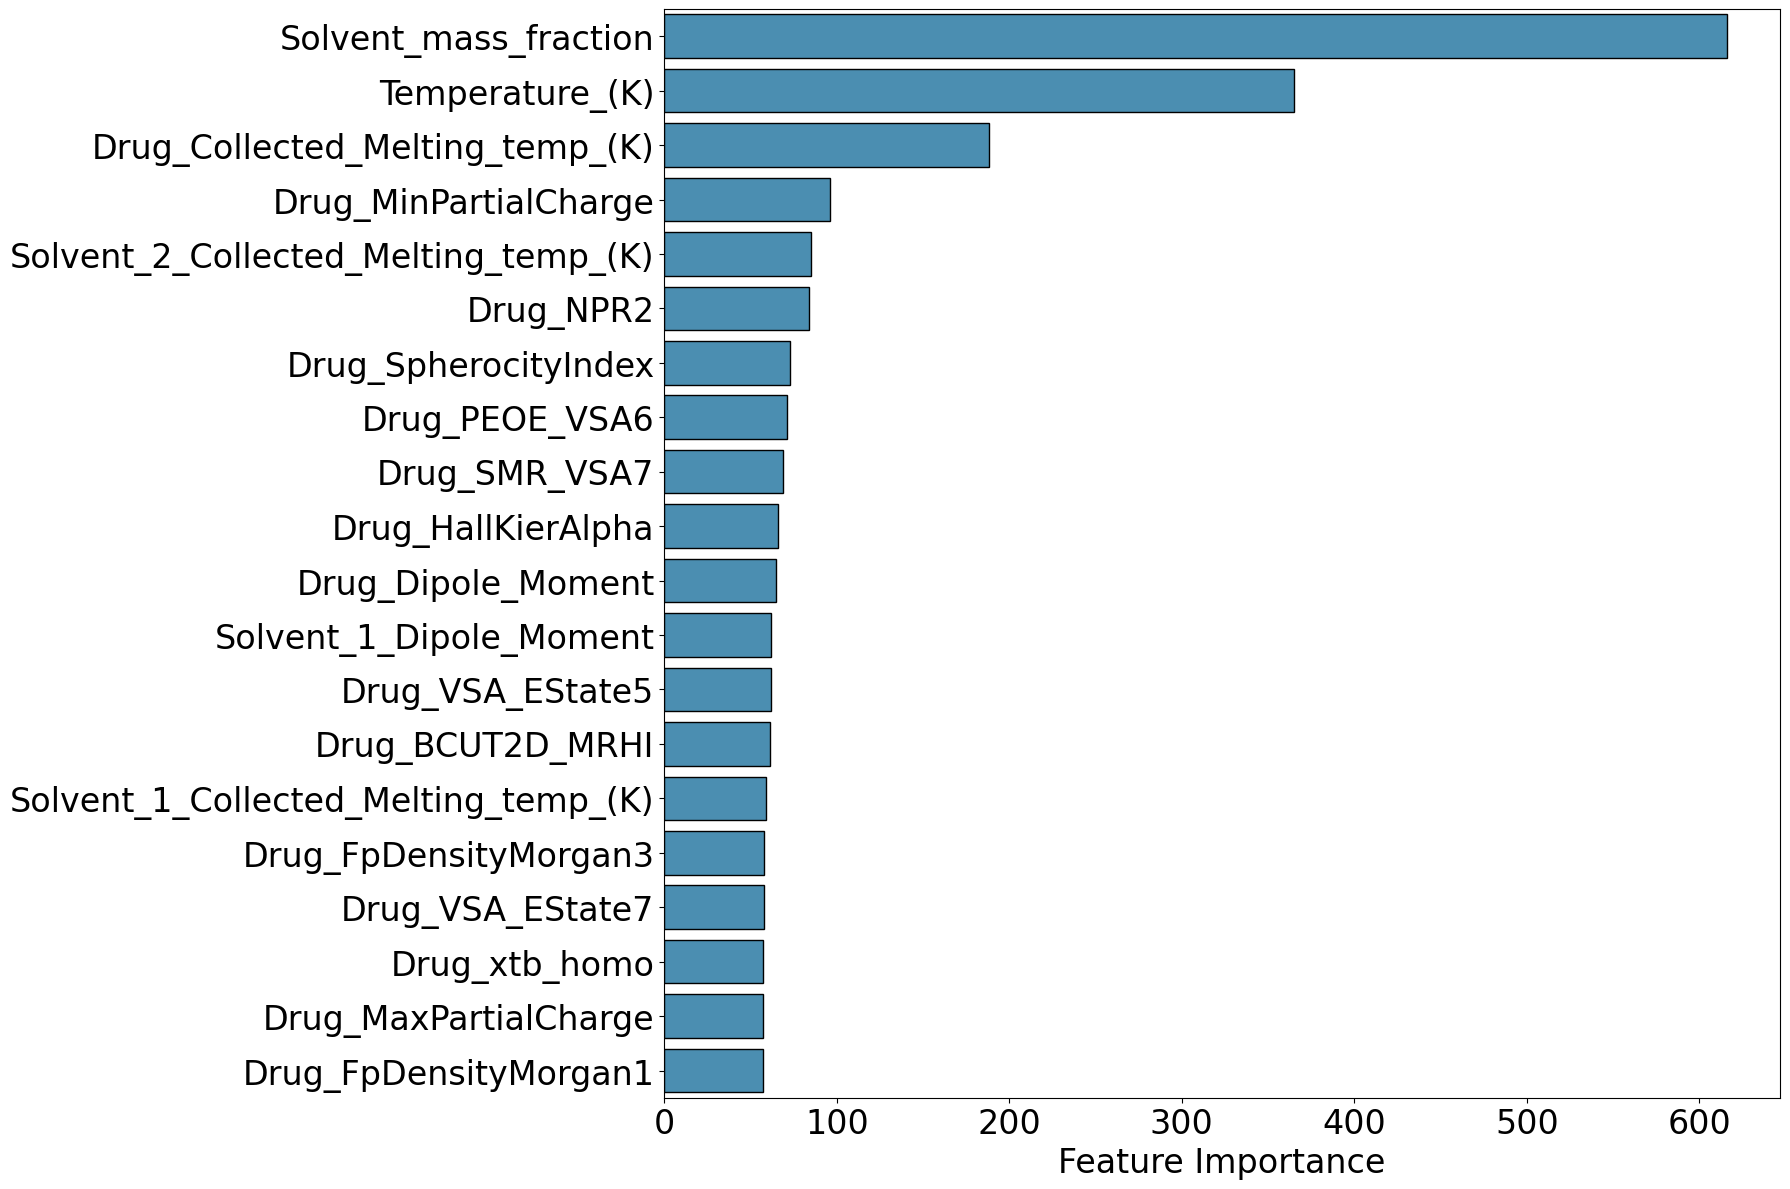

In [146]:
fig, ax1 = plt.subplots(figsize=(18, 12))
fontsize = 24

all_important_features = plot_feature_importance_lgb(model=best_model, ax=ax1, selected='', ann='', top_n=20, filter_drug_features=False)


ax1.set_xlabel('Feature Importance', fontsize=fontsize)  
ax1.set_ylabel('', fontsize=fontsize)  
ax1.tick_params(axis='x', labelsize=fontsize)  
ax1.tick_params(axis='y', labelsize=fontsize)  
plt.tight_layout()

fig.patch.set(facecolor='none')

fig.savefig('Figure_SI' + data_for + '_' + model_for + '_top 20 features.png', dpi=300)

plt.show()

In [147]:
important_features

,Feature,Importance
2,Drug_Collected_Melting_temp_(K),188
117,Drug_MinPartialCharge,96
231,Drug_NPR2,84
232,Drug_SpherocityIndex,73
139,Drug_PEOE_VSA6,71
149,Drug_SMR_VSA7,69
127,Drug_HallKierAlpha,66
229,Drug_Dipole_Moment,65
174,Drug_VSA_EState5,62
124,Drug_BCUT2D_MRHI,61


Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


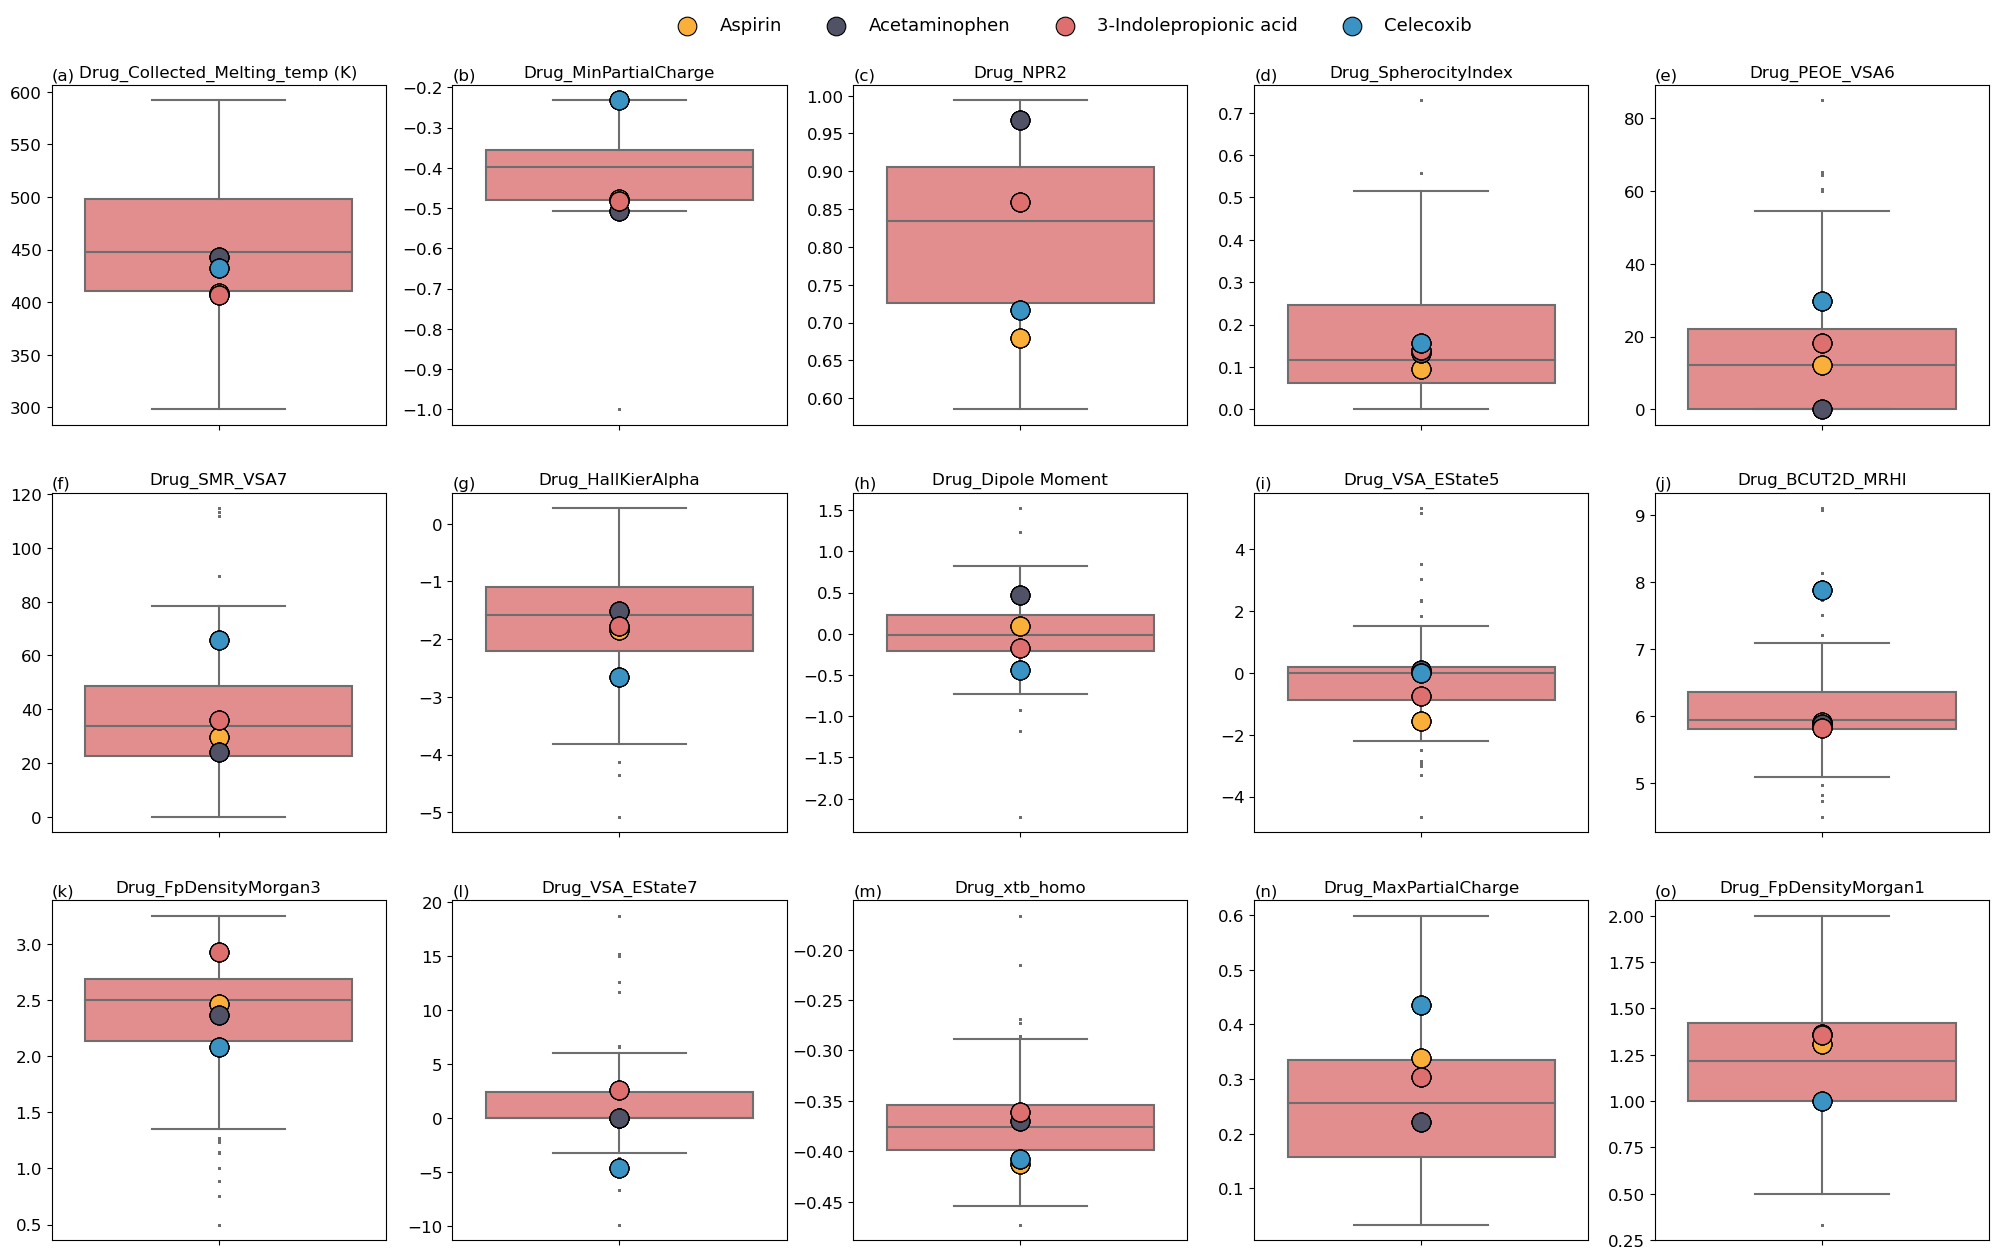

In [148]:

fig = plt.figure(figsize=(25, 15))  
gs = gridspec.GridSpec(3, 5, fig)  


for i, feature in enumerate(important_features['Feature']):
    row = i // 5  
    col = i % 5   
    ax = fig.add_subplot(gs[row, col])

    if (feature == 'Drug_Collected_Melting_temp_(K)'):
        feature = 'Drug_Collected_Melting_temp (K)'

    if (feature == 'Drug_Predicted_Melting_temp_(K)'):
        feature = 'Drug_Predicted_Melting_temp (K)'

    if (feature == 'Drug_Dipole_Moment'):
        feature = 'Drug_Dipole Moment'
    
    
    plot_distribution_with_labels_on_trend(
        ann=f'({chr(97+i)})',  
        prop=feature,
        ax=ax,
        show_legend=(i==14), legend_pos = (-3, 3.65), ncol = 4  
    )

plt.tight_layout()


fig.patch.set(facecolor='none')
fig.canvas.print_figure('Figure_SI_All_feature_' + model_for + data_for + '.png', dpi=600)

plt.show()




In [149]:
def print_summary_with_deviation_count():
    
    quantiles = literature_X.quantile([0.25, 0.75])
    
    
    unique_drugs = ['Acetaminophen', '3-Indolepropionic acid', 'Celecoxib', 'Aspirin']
    summary = []
    
    for feature in important_features['Feature']:


        if (feature == 'Drug_Collected_Melting_temp_(K)'):
            feature = 'Drug_Collected_Melting_temp (K)'

        if (feature == 'Drug_Predicted_Melting_temp_(K)'):
            feature = 'Drug_Predicted_Melting_temp (K)'

        if (feature == 'Drug_Dipole_Moment'):
            feature = 'Drug_Dipole Moment'
        
        Q1, Q3 = quantiles[feature].values
        for drug in unique_drugs:
            drug_data = lab_X[lab_X["Drug"] == drug]
            drug_feature_values = drug_data[feature]
            
            
            below_Q1 = drug_feature_values < Q1
            above_Q3 = drug_feature_values > Q3
            
            deviation = "deviates" if any(below_Q1) or any(above_Q3) else "does not deviate"
            
            summary.append([drug, feature, deviation])
    
    
    summary_df = pd.DataFrame(summary, columns=['Drug', 'Feature', 'Deviation'])
    summary_pivot = summary_df.pivot(index='Drug', columns='Feature', values='Deviation')
    
    
    deviation_counts = summary_df.groupby('Drug')['Deviation'].apply(lambda x: (x == "deviates").sum()).reset_index(name='Deviation Count')
    
    
    summary_with_counts = summary_pivot.merge(deviation_counts, left_on='Drug', right_on='Drug')
    summary_with_counts.set_index('Drug', inplace=True)
    
    
    columns_order = ['Deviation Count'] + [col for col in summary_with_counts if col != 'Deviation Count']
    summary_with_counts = summary_with_counts[columns_order]
    
    return summary_with_counts


summary_with_counts = print_summary_with_deviation_count()


In [150]:
summary_with_counts

,Deviation Count,Drug_BCUT2D_MRHI,Drug_Collected_Melting_temp (K),Drug_Dipole Moment,Drug_FpDensityMorgan1,Drug_FpDensityMorgan3,Drug_HallKierAlpha,Drug_MaxPartialCharge,Drug_MinPartialCharge,Drug_NPR2,Drug_PEOE_VSA6,Drug_SMR_VSA7,Drug_SpherocityIndex,Drug_VSA_EState5,Drug_VSA_EState7,Drug_xtb_homo
Drug,,,,,,,,,,,,,,,,
3-Indolepropionic acid,4,does not deviate,deviates,does not deviate,does not deviate,deviates,does not deviate,does not deviate,deviates,does not deviate,does not deviate,does not deviate,does not deviate,does not deviate,deviates,does not deviate
Acetaminophen,3,does not deviate,does not deviate,deviates,does not deviate,does not deviate,does not deviate,does not deviate,deviates,deviates,does not deviate,does not deviate,does not deviate,does not deviate,does not deviate,does not deviate
Aspirin,5,does not deviate,deviates,does not deviate,does not deviate,does not deviate,does not deviate,deviates,does not deviate,deviates,does not deviate,does not deviate,does not deviate,deviates,does not deviate,deviates
Celecoxib,11,deviates,does not deviate,deviates,does not deviate,deviates,deviates,deviates,deviates,deviates,deviates,deviates,does not deviate,does not deviate,deviates,deviates


In [151]:
literature_X

,Drug,Solvent_1,Solvent_mass_fraction,Solvent_mol_fraction,Solvent_2,Temperature (K),Drug_Collected_Melting_temp (K),Drug_Predicted_Melting_temp (K),Drug_SMILES,Drug_Maccs_1,...,Solvent_2_InertialShapeFactor,Solvent_2_Eccentricity,Solvent_2_Asphericity,Solvent_2_SpherocityIndex,Solvent_2_PBF,Solubility (g/100g),LogS,Class,Drug-solvent system,Type
0,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,0.925052,0.9406,4-Methyl-2-pentanone,293.15,511.150000,433.15,C(=C(N)N)(N(=O)=O)N(=O)=O,0,...,0.008987,0.929256,0.281062,0.433681,0.735697,27.381751,1.437461,"(1.0, 1.99]","1,1-Diamino-2,2-dinitroethylene-4-Methyl-2-pen...",Train
1,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,0.845707,0.8755,4-Methyl-2-pentanone,293.15,511.150000,433.15,C(=C(N)N)(N(=O)=O)N(=O)=O,0,...,0.008987,0.929256,0.281062,0.433681,0.735697,25.605519,1.408334,"(1.0, 1.99]","1,1-Diamino-2,2-dinitroethylene-4-Methyl-2-pen...",Train
2,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,0.761753,0.8040,4-Methyl-2-pentanone,293.15,511.150000,433.15,C(=C(N)N)(N(=O)=O)N(=O)=O,0,...,0.008987,0.929256,0.281062,0.433681,0.735697,23.248532,1.366396,"(1.0, 1.99]","1,1-Diamino-2,2-dinitroethylene-4-Methyl-2-pen...",Train
3,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,0.672768,0.7251,4-Methyl-2-pentanone,293.15,511.150000,433.15,C(=C(N)N)(N(=O)=O)N(=O)=O,0,...,0.008987,0.929256,0.281062,0.433681,0.735697,20.212869,1.305628,"(1.0, 1.99]","1,1-Diamino-2,2-dinitroethylene-4-Methyl-2-pen...",Train
4,"1,1-Diamino-2,2-dinitroethylene",Dimethyl sulfoxide,0.578193,0.6375,4-Methyl-2-pentanone,293.15,511.150000,433.15,C(=C(N)N)(N(=O)=O)N(=O)=O,0,...,0.008987,0.929256,0.281062,0.433681,0.735697,17.035467,1.231354,"(1.0, 1.99]","1,1-Diamino-2,2-dinitroethylene-4-Methyl-2-pen...",Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26701,"β-octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazo...",Dimethyl sulfoxide,0.812438,0.5000,Water,368.15,554.263333,513.15,N(=O)(=O)N1CN(N(=O)=O)CN(N(=O)=O)CN(N(=O)=O)C1,0,...,1.058974,0.942922,0.333653,0.000000,0.000000,29.061310,1.463315,"(1.0, 1.99]","β-octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazo...",Train
26702,"β-octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazo...",Dimethyl sulfoxide,0.722140,0.3750,Water,368.15,554.263333,513.15,N(=O)(=O)N1CN(N(=O)=O)CN(N(=O)=O)CN(N(=O)=O)C1,0,...,1.058974,0.942922,0.333653,0.000000,0.000000,14.117746,1.149765,"(1.0, 1.99]","β-octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazo...",Train
26703,"β-octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazo...",Dimethyl sulfoxide,0.590810,0.2500,Water,368.15,554.263333,513.15,N(=O)(=O)N1CN(N(=O)=O)CN(N(=O)=O)CN(N(=O)=O)C1,0,...,1.058974,0.942922,0.333653,0.000000,0.000000,3.854105,0.585924,"(0.36, 1.0]","β-octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazo...",Train
26704,"β-octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazo...",Dimethyl sulfoxide,0.382257,0.1250,Water,368.15,554.263333,513.15,N(=O)(=O)N1CN(N(=O)=O)CN(N(=O)=O)CN(N(=O)=O)C1,0,...,1.058974,0.942922,0.333653,0.000000,0.000000,1.121013,0.049611,"(-0.43, 0.36]","β-octahydro-1,3,5,7-tetranitro-1,3,5,7-tetrazo...",Train


In [152]:
lab_X

,Drug,Solvent_1,Solvent_mass_fraction,Solvent_mol_fraction,Solvent_2,Temperature (K),Drug_Collected_Melting_temp (K),Drug_Predicted_Melting_temp (K),Drug_SMILES,Drug_Maccs_1,...,Solvent_2_InertialShapeFactor,Solvent_2_Eccentricity,Solvent_2_Asphericity,Solvent_2_SpherocityIndex,Solvent_2_PBF,Solubility (g/100g),LogS,Class,Drug-solvent system,Type
26706,Celecoxib,Ethanol,0.2,0.089083,Water,298.15,432.816667,453.15,C(F)(F)(F)C1=NN(C(=C1)C2=CC=C(C)C=C2)C3=CC=C(S...,0,...,1.058974,0.942922,0.333653,0.0,0.0,0.000869,-3.061188,NaN,Celecoxib-Ethanol/Water,Celecoxib
26707,Celecoxib,Ethanol,0.5,0.281185,Water,298.15,432.816667,453.15,C(F)(F)(F)C1=NN(C(=C1)C2=CC=C(C)C=C2)C3=CC=C(S...,0,...,1.058974,0.942922,0.333653,0.0,0.0,0.445512,-0.351141,NaN,Celecoxib-Ethanol/Water,Celecoxib
26708,Celecoxib,Ethanol,0.8,0.610093,Water,298.15,432.816667,453.15,C(F)(F)(F)C1=NN(C(=C1)C2=CC=C(C)C=C2)C3=CC=C(S...,0,...,1.058974,0.942922,0.333653,0.0,0.0,4.842238,0.685046,NaN,Celecoxib-Ethanol/Water,Celecoxib
26709,Celecoxib,Ethanol,0.2,0.089083,Water,313.15,432.816667,453.15,C(F)(F)(F)C1=NN(C(=C1)C2=CC=C(C)C=C2)C3=CC=C(S...,0,...,1.058974,0.942922,0.333653,0.0,0.0,0.003120,-2.505811,NaN,Celecoxib-Ethanol/Water,Celecoxib
26710,Celecoxib,Ethanol,0.5,0.281185,Water,313.15,432.816667,453.15,C(F)(F)(F)C1=NN(C(=C1)C2=CC=C(C)C=C2)C3=CC=C(S...,0,...,1.058974,0.942922,0.333653,0.0,0.0,1.026914,0.011534,NaN,Celecoxib-Ethanol/Water,Celecoxib
26711,Celecoxib,Ethanol,0.8,0.610093,Water,313.15,432.816667,453.15,C(F)(F)(F)C1=NN(C(=C1)C2=CC=C(C)C=C2)C3=CC=C(S...,0,...,1.058974,0.942922,0.333653,0.0,0.0,8.576122,0.933291,NaN,Celecoxib-Ethanol/Water,Celecoxib
26712,Acetaminophen,Ethanol,0.2,0.089083,Water,298.15,443.253333,433.15,N(C(C)=O)C1=CC=C(O)C=C1,0,...,1.058974,0.942922,0.333653,0.0,0.0,3.699358,0.568126,NaN,Acetaminophen-Ethanol/Water,Acetaminophen
26713,Acetaminophen,Ethanol,0.5,0.281185,Water,298.15,443.253333,433.15,N(C(C)=O)C1=CC=C(O)C=C1,0,...,1.058974,0.942922,0.333653,0.0,0.0,14.634461,1.165377,NaN,Acetaminophen-Ethanol/Water,Acetaminophen
26714,Acetaminophen,Ethanol,0.8,0.610093,Water,298.15,443.253333,433.15,N(C(C)=O)C1=CC=C(O)C=C1,0,...,1.058974,0.942922,0.333653,0.0,0.0,19.081476,1.280612,NaN,Acetaminophen-Ethanol/Water,Acetaminophen
26715,Acetaminophen,Ethanol,0.2,0.089083,Water,313.15,443.253333,433.15,N(C(C)=O)C1=CC=C(O)C=C1,0,...,1.058974,0.942922,0.333653,0.0,0.0,6.761074,0.830016,NaN,Acetaminophen-Ethanol/Water,Acetaminophen


# Clusters and M_distances

In [153]:
def filter_drug_columns(df):

    drug_columns = [col for col in df.columns if col.startswith('Drug')]

    new_df = df[drug_columns]
    new_df = new_df.drop(['Drug-solvent system'], axis = 1)
    new_df = new_df.drop_duplicates()

    # cols_to_drop = ['Solvent_1', 'Solvent_2', 'Solubility (g/100g)', 'Type', 'Class', 'Drug-solvent system', 'LogS']
    # new_df = df.drop(cols_to_drop, axis=1)

    
    return new_df


In [154]:
drug_lab = filter_drug_columns(lab_X)
drug_lab

,Drug,Drug_Collected_Melting_temp (K),Drug_Predicted_Melting_temp (K),Drug_SMILES,Drug_Maccs_1,Drug_Maccs_2,Drug_Maccs_3,Drug_Maccs_4,Drug_Maccs_5,Drug_Maccs_6,...,Drug_PMI2,Drug_PMI3,Drug_NPR1,Drug_NPR2,Drug_RadiusOfGyration,Drug_InertialShapeFactor,Drug_Eccentricity,Drug_Asphericity,Drug_SpherocityIndex,Drug_PBF
26706,Celecoxib,432.816667,453.15,C(F)(F)(F)C1=NN(C(=C1)C2=CC=C(C)C=C2)C3=CC=C(S...,0,0,0,0,0,0,...,4685.011507,6531.901252,0.342783,0.717251,4.200139,0.000320,0.939414,0.307326,0.155463,0.764582
26712,Acetaminophen,443.253333,433.15,N(C(C)=O)C1=CC=C(O)C=C1,0,0,0,0,0,0,...,946.391721,978.172401,0.146220,0.967510,2.615122,0.006764,0.989252,0.628719,0.132365,0.464433
26718,3-Indolepropionic acid,407.150000,413.15,C(CC(O)=O)C=1C=2C(NC1)=CC=CC2,0,0,0,0,0,0,...,1369.540630,1593.170668,0.218674,0.859632,2.957974,0.002467,0.975798,0.482016,0.139820,0.509073
26724,Aspirin,409.150000,403.15,C(O)(=O)C1=C(OC(C)=O)C=CC=C1,0,0,0,0,0,0,...,686.876698,1011.120557,0.421889,0.679322,2.428250,0.001592,0.906647,0.227999,0.094075,0.396410


In [155]:
drug_literature = filter_drug_columns(literature_X)
drug_literature

,Drug,Drug_Collected_Melting_temp (K),Drug_Predicted_Melting_temp (K),Drug_SMILES,Drug_Maccs_1,Drug_Maccs_2,Drug_Maccs_3,Drug_Maccs_4,Drug_Maccs_5,Drug_Maccs_6,...,Drug_PMI2,Drug_PMI3,Drug_NPR1,Drug_NPR2,Drug_RadiusOfGyration,Drug_InertialShapeFactor,Drug_Eccentricity,Drug_Asphericity,Drug_SpherocityIndex,Drug_PBF
0,"1,1-Diamino-2,2-dinitroethylene",511.150000,433.15,C(=C(N)N)(N(=O)=O)N(=O)=O,0,0,0,0,0,0,...,365.307976,595.272252,0.515981,0.613682,2.068964,0.001998,0.856600,0.173328,0.149091,0.320117
279,"1,3-Phenylenediamine",337.316667,349.15,NC1=CC(N)=CC=C1,0,0,0,0,0,0,...,281.503660,411.328394,0.328005,0.684377,1.956290,0.005073,0.944676,0.334938,0.078973,0.210794
744,"2,5-Furandicarboxylic acid",583.150000,513.15,C(O)(=O)C=1OC(C(O)=O)=CC1,0,0,0,0,0,0,...,849.704835,1016.995214,0.164577,0.835505,2.552564,0.004992,0.986364,0.587519,0.000750,0.030836
1124,2-(Diacetoxymethyl)-5-nitrofuran,363.983333,350.15,C(OC(C)=O)(OC(C)=O)C=1OC(N(=O)=O)=CC1,0,0,0,0,0,0,...,1995.556729,2379.907585,0.334197,0.838502,3.260686,0.001054,0.942503,0.306611,0.253796,0.814828
1204,"2-Amino-3,5-dibromopyrazine",388.150000,433.15,NC1=NC=C(Br)N=C1Br,0,0,0,0,0,0,...,1455.972314,1755.678109,0.171340,0.829293,2.635235,0.002757,0.985212,0.573997,0.023599,0.120278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26143,Tiopronin,369.650000,383.15,C(NCC(O)=O)(C(C)S)=O,0,0,0,0,0,0,...,810.092926,878.567664,0.252383,0.922061,2.419298,0.004158,0.967627,0.428693,0.297965,0.668737
26343,Trans-4-Hydroxy‐L‐proline,547.483333,463.15,C(O)(=O)[C@@H]1C[C@@H](O)CN1,0,0,0,0,0,0,...,492.748468,583.665345,0.235813,0.844231,2.151545,0.006134,0.971798,0.452282,0.339049,0.602657
26388,Ursolic acid,560.983333,543.15,C(O)(=O)[C@]12[C@](C=3[C@@](C)(CC1)[C@@]4(C)[C...,0,0,0,0,0,0,...,6920.061892,7202.422169,0.213311,0.960796,4.140417,0.000625,0.976984,0.498927,0.341247,1.290433
26442,Vinpocetine,422.983333,423.15,C(C)[C@]12[C@]3(C=4N(C=5C(C4CCN3CCC1)=CC=CC5)C...,0,0,0,0,0,0,...,2551.011647,4156.206064,0.444864,0.613784,3.493849,0.000332,0.895598,0.229292,0.145748,0.672900


In [156]:
data_for

'_ExpMP'

In [157]:
if data_for == '_ExpMP':
    to_drop = ['Drug_SMILES', 'Drug_Predicted_Melting_temp (K)']

elif data_for == '_PredMP':
    to_drop = ['Drug_SMILES', 'Drug_Collected_Melting_temp (K)']

elif data_for == '_NoMP':
    to_drop = ['Drug_SMILES', 'Drug_Predicted_Melting_temp (K)', 'Drug_Collected_Melting_temp (K)']

print(to_drop)

drug_literature = drug_literature.drop(to_drop, axis=1)
drug_lab = drug_lab.drop(to_drop, axis=1)

['Drug_SMILES', 'Drug_Predicted_Melting_temp (K)']


In [158]:
drug_lab

,Drug,Drug_Collected_Melting_temp (K),Drug_Maccs_1,Drug_Maccs_2,Drug_Maccs_3,Drug_Maccs_4,Drug_Maccs_5,Drug_Maccs_6,Drug_Maccs_7,Drug_Maccs_8,...,Drug_PMI2,Drug_PMI3,Drug_NPR1,Drug_NPR2,Drug_RadiusOfGyration,Drug_InertialShapeFactor,Drug_Eccentricity,Drug_Asphericity,Drug_SpherocityIndex,Drug_PBF
26706,Celecoxib,432.816667,0,0,0,0,0,0,0,0,...,4685.011507,6531.901252,0.342783,0.717251,4.200139,0.000320,0.939414,0.307326,0.155463,0.764582
26712,Acetaminophen,443.253333,0,0,0,0,0,0,0,0,...,946.391721,978.172401,0.146220,0.967510,2.615122,0.006764,0.989252,0.628719,0.132365,0.464433
26718,3-Indolepropionic acid,407.150000,0,0,0,0,0,0,0,0,...,1369.540630,1593.170668,0.218674,0.859632,2.957974,0.002467,0.975798,0.482016,0.139820,0.509073
26724,Aspirin,409.150000,0,0,0,0,0,0,0,0,...,686.876698,1011.120557,0.421889,0.679322,2.428250,0.001592,0.906647,0.227999,0.094075,0.396410


In [159]:
X_literature = drug_literature.iloc[:, 1:].values
X_lab = drug_lab.iloc[:, 1:].values
drug_names = drug_lab.iloc[:, 0].values


scaler = StandardScaler()
X_literature_scaled = scaler.fit_transform(X_literature)
X_lab_scaled = scaler.transform(X_lab)


kmeans = KMeans(random_state=0)
clusters = kmeans.fit_predict(X_literature_scaled)


cluster_sizes = pd.Series(clusters).value_counts().sort_index()


unique_clusters = np.unique(clusters)

distance_matrix = pd.DataFrame(index=unique_clusters, columns=drug_names)


for cluster_id in unique_clusters:
    cluster_points = X_literature_scaled[clusters == cluster_id]

    if cluster_points.shape[0] <= 1:
        print(f"Cluster {cluster_id} has too few points for covariance calculation.")
        continue

    mean = np.mean(cluster_points, axis=0)
    cov_matrix = np.cov(cluster_points, rowvar=False)
    
    inv_cov_matrix = np.linalg.pinv(cov_matrix)
    
    for i, point in enumerate(X_lab_scaled):
        distance = mahalanobis(point, mean, inv_cov_matrix)
        distance_matrix.at[cluster_id, drug_names[i]] = distance


distance_matrix.fillna('NaN', inplace=True)
distance_matrix['Cluster Size'] = cluster_sizes


distance_matrix = distance_matrix.astype(float, errors='ignore')


In [160]:
distance_matrix.to_excel('Table' + data_for + '_M_distances.xlsx')
distance_matrix

,Celecoxib,Acetaminophen,3-Indolepropionic acid,Aspirin,Cluster Size
0,0.770102,0.457042,0.381129,0.195513,3.0
1,7.947899,5.526602,3.674118,6.211095,35.0
2,2.979998,3.460092,3.072291,2.562394,18.0
3,0.639658,0.946121,0.924298,0.877127,6.0
4,2.474874,1.125950,2.336252,1.765716,8.0
5,4.037546,4.419697,4.785954,5.170980,6.0
6,7.682310,6.084870,6.090150,4.960641,39.0
7,1.170351,1.960458,1.707460,1.754404,8.0


# Lab drug similarity

In [161]:
sim_data = pd.read_csv("../Exp_1_Raw_Dataset/Raw_dataset_dataset_20240705.csv")
sim_data = sim_data[['Drug', 'Drug_SMILES', 'Type']]
sim_data

,Drug,Drug_SMILES,Type
0,"1,1-Diamino-2,2-dinitroethylene",C(=C(N)N)(N(=O)=O)N(=O)=O,Train
1,"1,1-Diamino-2,2-dinitroethylene",C(=C(N)N)(N(=O)=O)N(=O)=O,Train
2,"1,1-Diamino-2,2-dinitroethylene",C(=C(N)N)(N(=O)=O)N(=O)=O,Train
3,"1,1-Diamino-2,2-dinitroethylene",C(=C(N)N)(N(=O)=O)N(=O)=O,Train
4,"1,1-Diamino-2,2-dinitroethylene",C(=C(N)N)(N(=O)=O)N(=O)=O,Train
...,...,...,...
26725,Aspirin,C(O)(=O)C1=C(OC(C)=O)C=CC=C1,Lab
26726,Aspirin,C(O)(=O)C1=C(OC(C)=O)C=CC=C1,Lab
26727,Aspirin,C(O)(=O)C1=C(OC(C)=O)C=CC=C1,Lab
26728,Aspirin,C(O)(=O)C1=C(OC(C)=O)C=CC=C1,Lab


In [162]:
sim_lab = sim_data[sim_data['Type'] == 'Lab']
sim_lab = sim_lab.drop(['Type'], axis=1)
sim_lab = sim_lab.drop_duplicates()
sim_lab

,Drug,Drug_SMILES
26706,Celecoxib,C(F)(F)(F)C1=NN(C(=C1)C2=CC=C(C)C=C2)C3=CC=C(S...
26712,Acetaminophen,N(C(C)=O)C1=CC=C(O)C=C1
26718,3-Indolepropionic acid,C(CC(O)=O)C=1C=2C(NC1)=CC=CC2
26724,Aspirin,C(O)(=O)C1=C(OC(C)=O)C=CC=C1


In [163]:
lab_drugs = sim_lab['Drug'].values
lab_smiles = sim_lab['Drug_SMILES'].values


similarity_df_lab = pd.DataFrame(index=lab_drugs, columns=lab_drugs)


for i, lab_smile_1 in enumerate(lab_smiles):
    mol_lab_1 = Chem.MolFromSmiles(lab_smile_1)
    fp_lab_1 = AllChem.GetMorganFingerprintAsBitVect(mol_lab_1, 2, nBits=2048)
    for j, lab_smile_2 in enumerate(lab_smiles):
        mol_lab_2 = Chem.MolFromSmiles(lab_smile_2)
        fp_lab_2 = AllChem.GetMorganFingerprintAsBitVect(mol_lab_2, 2, nBits=2048)
        similarity = DataStructs.TanimotoSimilarity(fp_lab_1, fp_lab_2)
        similarity_df_lab.iloc[i, j] = float(similarity)


similarity_df_lab = similarity_df_lab.astype(float)

In [164]:
similarity_df_lab = round(similarity_df_lab,3)


similarity_df_lab.to_excel('Lab_drug_similarity.xlsx')
similarity_df_lab

,Celecoxib,Acetaminophen,3-Indolepropionic acid,Aspirin
Celecoxib,1.000,0.091,0.078,0.085
Acetaminophen,0.091,1.000,0.140,0.222
3-Indolepropionic acid,0.078,0.140,1.000,0.205
Aspirin,0.085,0.222,0.205,1.000


In [165]:

mask = np.tril(np.ones(similarity_df_lab.shape), k=-1).astype(bool)
lower_triangle_values = similarity_df_lab.where(mask).stack()


mean_value = lower_triangle_values.mean()
std_value = lower_triangle_values.std()

round(mean_value,3), round(std_value,3)

(0.137, 0.063)